(Validation_Strategies)=
# Validation strategies


The purpose of a fraud detection system is to maximize the detection of fraudulent transactions that will occur in the *future*. 

The most straightforward approach for training and evaluating a prediction model for a fraud detection system is illustrated in Fig. 1. For clarity of the illustration, the stream of transaction data is discretized in blocks. A block corresponds to a time period (such as one week or one day). We assume that the prediction model should be updated every new block {cite}`dal2017credit,dal2015adaptive`. 

This is the approach that we used in the section {ref}`Baseline_FDS`. Blocks corresponded to one week of transaction data. One block of data was used for training, and one block of data for testing. A one-week delay was also used to separate the training and test blocks.

More generally, given a set of past transactions blocks collected up to the current time $t$, the purpose of the prediction model is to provide predictions for transactions that will occur in the next block (*future* transactions, also called *test* transactions, in yellow) {cite}`dal2017credit,dal2015adaptive`. The set of blocks that are used for training are the *training blocks* (in dark blue). Due to the delay in obtaining transaction labels (See the section {ref}`Fraud_Detection_System`), the most recent transactions usually cannot be used for training (delay period, in light blue) and are removed. Older blocks are also usually discarded, due to concept drift (in light blue, also removed). Let us denote the lengths of the training, delay, and test periods by $\delta_{train}$, $\delta_{delay}$, and $\delta_{test}$, respectively.

![alt text](images/stream_train.png)
<div align="center">Fig. 1. The purpose of a prediction model for fraud detection is to provide predictions for transactions that occur in the future (in yellow). The model is trained on a set of past transactions (in dark blue).</div>

The performance of a model on training data is often a bad indicator of the performance on future data {cite}`bontempi2021statistical,bishop2006pattern,friedman2001elements`. The former is referred to as *training performance*, and the latter as *test performance* (that is, the performance of the model when *tested* on unseen data). In particular, increasing the degree of freedom of a model (such as the depth for a decision tree) always allows to increase the training performance, but usually leads to lower test performances (*overfitting* phenomenon). 

Validation procedures aim at solving this issue by estimating, on past data, the test performance of a prediction model by setting aside a part of them {cite}`cerqueira2020evaluating,gama2014survey`. They work by splitting the past labeled data into two sets, the *training set* and the *validation set*, that simulate the setting of a real-world fraud detection system. The validation set plays the role of the test set. This is illustrated in Fig. 2. 

![alt text](images/stream_valid.png)
<div align="center">Fig. 2. A validation procedure simulates on past data the training procedure that will be used to provide predictions on test (unseen) data. It uses the validation set to estimate the performance of the test stage. </div>

In order to best simulate the setup illustrated in Fig. 1, the training and validation sets are separated with the same delay period. The length of the validation set ($\delta_{valid}$) is set equal to the length of the test set ($\delta_{test}$). The performance of a model on the validation set is used as an estimate of the performance that is expected on the test set. 

The validation strategy illustrated in Fig. 2 is called *hold-out validation* (since part of the available labeled transactions is held out of the training data). Variants of this approach are the *repeated hold-out validation* and the *prequential validation*. The former is the same as the *hold-out* validation except that the procedure is repeated several times using different subsets of the training data. The latter is a variant that repeats hold-out validation by shifting the training and validation sets in the past. Both repeated hold-out and prequential validations allow providing estimates of performances on the test set, together with confidence intervals {cite}`cerqueira2020evaluating,gama2014survey`.

The next sections detail these validation procedures. We first illustrate using simulated data and decision trees that the training performance is a bad estimate of the test performance. We then provide implementations of the hold-out, repeated hold-out, and prequential validations, and discuss their pros and cons. 


In [1]:
# Initialization: Load shared functions and simulated data 

# Load shared functions
!curl -O https://raw.githubusercontent.com/Fraud-Detection-Handbook/fraud-detection-handbook/main/Chapter_References/shared_functions.py
%run shared_functions.py

# Get simulated data from Github repository
if not os.path.exists("simulated-data-transformed"):
    !git clone https://github.com/Fraud-Detection-Handbook/simulated-data-transformed
        

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 41751  100 41751    0     0   147k      0 --:--:-- --:--:-- --:--:--  147k


(Training_Vs_Test_Performances)=
## Training performance versus test performance

We first illustrate that the training performance is a bad indicator of the test performance. We reuse the same experimental setup as in Chapter 3 - {ref}`Baseline_FDS`. One week of data is used for training the prediction model, and one week of data for testing the predictions. We rely on a decision tree model, and assess the training and test performances for decision trees with different tree depths, ranging from two to fifty. Performances are assessed in terms of ROC AUC, Average Precision, and Card Precision@100 as was motivated in Chapter 4 - {ref}`Performance_Metrics`.

Let us first load the simulated data, and set the output feature and input features as in the section {ref}`Baseline_FDS_Decision_Tree`.

In [2]:
# Note: We load more data than three weeks, as the experiments in the next sections
# will require up to three months of data

# Load data from the 2018-06-11 to the 2018-09-14

DIR_INPUT='simulated-data-transformed/data/' 

BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']


Load  files
CPU times: user 1.04 s, sys: 778 ms, total: 1.82 s
Wall time: 2.16 s
919767 transactions loaded, containing 8195 fraudulent transactions


Using one week for training, one week for testing, and one week of delay corresponds to the experimental setup that is illustrated in Fig. 3. 

![alt text](images/stream_train_1block.png)
<div align="center">Fig. 3. Experimental setup where one week of data is used for training and one week of data for testing, separated by a one week delay. Each block corresponds to one week of data.</div>

Let us set the start of the training period to the 2018-07-25, and the deltas for training, delay, and test to 7 days (one week). 

In [3]:
# Set the starting day for the training period, and the deltas
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train=7
delta_delay=7
delta_test=7


We define a function `get_performances_train_test_sets` for training a model, and assessing its performances on the training and test sets. The function performs the same steps as those outlined in the section {ref}`Baseline_FDS`. The four main steps are:

* Setting the start date for the training period, and the deltas for training, delay and test
* Getting the training and test sets
* Fitting the model and collecting the predictions
* Assessing the performances for both the training and test sets



In [4]:
def get_performances_train_test_sets(transactions_df, classifier,
                                     input_features, output_feature,
                                     start_date_training, 
                                     delta_train=7, delta_delay=7, delta_test=7,
                                     top_k_list=[100],
                                     type_test="Test", parameter_summary=""):

    # Get the training and test sets
    (train_df, test_df)=get_train_test_set(transactions_df,start_date_training,
                                           delta_train=delta_train,
                                           delta_delay=delta_delay,
                                           delta_test=delta_test)
    
    # Fit model
    start_time=time.time() 
    model_and_predictions_dictionary = fit_model_and_get_predictions(classifier, train_df, test_df, 
                                                                     input_features, output_feature)
    execution_time=time.time()-start_time
    
    # Compute fraud detection performances
    test_df['predictions']=model_and_predictions_dictionary['predictions_test']
    performances_df_test=performance_assessment(test_df, top_k_list=top_k_list)
    performances_df_test.columns=performances_df_test.columns.values+' '+type_test
    
    train_df['predictions']=model_and_predictions_dictionary['predictions_train']
    performances_df_train=performance_assessment(train_df, top_k_list=top_k_list)
    performances_df_train.columns=performances_df_train.columns.values+' Train'
    
    performances_df=pd.concat([performances_df_test,performances_df_train],axis=1)
    
    performances_df['Execution time']=execution_time
    performances_df['Parameters summary']=parameter_summary
    
    return performances_df


Let us for example compute the test and training accuracies using a decision tree with depth 2. 

In [7]:
classifier = sklearn.tree.DecisionTreeClassifier(max_depth=2, random_state=0)

performances_df=get_performances_train_test_sets(transactions_df, classifier, 
                                                 input_features, output_feature,
                                                 start_date_training=start_date_training, 
                                                 delta_train=delta_train, 
                                                 delta_delay=delta_delay, 
                                                 delta_test=delta_test,
                                                 parameter_summary=2
                                                )

In [8]:
performances_df

,AUC ROC Test,Average precision Test,Card Precision@100 Test,AUC ROC Train,Average precision Train,Card Precision@100 Train,Execution time,Parameters summary
0,0.763,0.496,0.241,0.802,0.586,0.394,0.451595,2


Note that the performances are the same as those obtained in the section {ref}`Baseline_FDS_Performances_Simulation`.

We can then compute the performances for varying decision tree depths. Let us vary the decision tree depths from two to fifty, using the following values: $[2,3,4,5,6,7,8,9,10,20,50]$.

In [9]:
list_params = [2,3,4,5,6,7,8,9,10,20,50]

performances_df=pd.DataFrame()

for max_depth in list_params:
    
    classifier = sklearn.tree.DecisionTreeClassifier(max_depth = max_depth, random_state=0)

    performances_df=performances_df.append(
        get_performances_train_test_sets(transactions_df, classifier, 
                                         input_features, output_feature, 
                                         start_date_training=start_date_training, 
                                         delta_train=delta_train, 
                                         delta_delay=delta_delay, 
                                         delta_test=delta_test,            
                                         parameter_summary=max_depth
                           )
    )
    
performances_df.reset_index(inplace=True,drop=True)

In [10]:
performances_df

,AUC ROC Test,Average precision Test,Card Precision@100 Test,AUC ROC Train,Average precision Train,Card Precision@100 Train,Execution time,Parameters summary
0,0.763,0.496,0.241,0.802,0.586,0.394,0.468689,2
1,0.795,0.562,0.267,0.815,0.615,0.409,0.582330,3
2,0.802,0.570,0.269,0.829,0.635,0.411,0.550253,4
3,0.814,0.581,0.280,0.835,0.649,0.419,0.580715,5
4,0.817,0.588,0.280,0.842,0.662,0.421,0.642127,6
5,0.793,0.542,0.254,0.876,0.679,0.427,0.666566,7
6,0.786,0.546,0.257,0.884,0.717,0.436,0.727614,8
7,0.756,0.499,0.246,0.896,0.737,0.437,0.773424,9
8,0.750,0.484,0.244,0.901,0.756,0.440,0.782423,10
9,0.739,0.392,0.243,0.974,0.907,0.506,1.194687,20


For better visualization of the results, let us plot the resulting performances in terms of AUC ROC, AP, and CP@100, as a function of the decision tree depth. 

In [11]:
# Get the performance plot for a single performance metric
def get_performance_plot(performances_df, 
                         ax, 
                         performance_metric, 
                         expe_type_list=['Test','Train'], 
                         expe_type_color_list=['#008000','#2F4D7E'],
                         parameter_name="Tree maximum depth",
                         summary_performances=None):
    
    # expe_type_list is the list of type of experiments, typically containing 'Test', 'Train', or 'Valid'
    # For all types of experiments
    for i in range(len(expe_type_list)):
    
        # Column in performances_df for which to retrieve the data 
        performance_metric_expe_type=performance_metric+' '+expe_type_list[i]
    
        # Plot data on graph
        ax.plot(performances_df['Parameters summary'], performances_df[performance_metric_expe_type], 
                color=expe_type_color_list[i], label = expe_type_list[i])
        
        # If performances_df contains confidence intervals, add them to the graph
        if performance_metric_expe_type+' Std' in performances_df.columns:
        
            conf_min = performances_df[performance_metric_expe_type]\
                        -2*performances_df[performance_metric_expe_type+' Std']
            conf_max = performances_df[performance_metric_expe_type]\
                        +2*performances_df[performance_metric_expe_type+' Std']
    
            ax.fill_between(performances_df['Parameters summary'], conf_min, conf_max, color=expe_type_color_list[i], alpha=.1)

    # If summary_performances table is present, adds vertical dashed bar for best estimated parameter 
    if summary_performances is not None:
        best_estimated_parameter=summary_performances[performance_metric][['Best estimated parameters ($k^*$)']].values[0]
        best_estimated_performance=float(summary_performances[performance_metric][['Validation performance']].values[0].split("+/-")[0])
        ymin, ymax = ax.get_ylim()
        ax.vlines(best_estimated_parameter, ymin, best_estimated_performance,
                  linestyles="dashed")
    
    # Set title, and x and y axes labels
    ax.set_title(performance_metric+'\n', fontsize=14)
    ax.set(xlabel = parameter_name, ylabel=performance_metric)

# Get the performance plots for a set of performance metric
def get_performances_plots(performances_df, 
                           performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                           expe_type_list=['Test','Train'], expe_type_color_list=['#008000','#2F4D7E'],
                           parameter_name="Tree maximum depth",
                           summary_performances=None):
    
    # Create as many graphs as there are performance metrics to display
    n_performance_metrics = len(performance_metrics_list)
    fig, ax = plt.subplots(1, n_performance_metrics, figsize=(5*n_performance_metrics,4))
    
    # Plot performance metric for each metric in performance_metrics_list
    for i in range(n_performance_metrics):
    
        get_performance_plot(performances_df, ax[i], performance_metric=performance_metrics_list[i], 
                             expe_type_list=expe_type_list, 
                             expe_type_color_list=expe_type_color_list,
                             parameter_name=parameter_name,
                             summary_performances=summary_performances)
    
    ax[n_performance_metrics-1].legend(loc='upper left', 
                                       labels=expe_type_list, 
                                       bbox_to_anchor=(1.05, 1),
                                       title="Type set")

    plt.subplots_adjust(wspace=0.5, 
                        hspace=0.8)

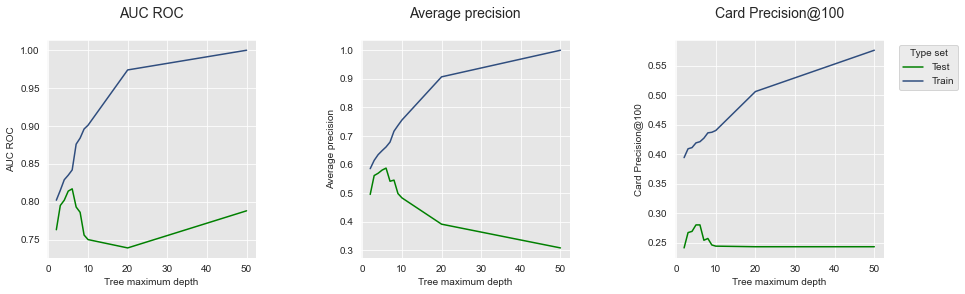

In [12]:
get_performances_plots(performances_df, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Train'],expe_type_color_list=['#008000','#2F4D7E'])

The training performance is plotted in blue, and the test performance in green. The graph clearly illustrates the *overfitting* phenomenon: The training performance keeps increasing with the tree depth and reaches a perfect fit, i.e. the highest possible AUC ROC/AP, for a depth of fifty. The test performance however peaks at a depth of 6. A depth of 6 is therefore the depth that maximizes the performance on the test set when a decision tree is used as a prediction model. 

Let us also recall that the Card Precision@100 is the metric that is of highest interest for fraud investigators. It is worth noting that the AUC ROC on the test set has a different dynamic than the CP@100: For the highest tree depth of fifty, the accuracy in terms of AUC ROC increases, whereas the CP@100 remains low. This illustrates experimentally that the AUC ROC is not a well-suited metric for fraud investigators.

(Hold_Out_Validation)=
## Hold-out validation



As illustrated above, the training performance does not provide guidance on how to select the prediction model that performs best on test data. Let us also recall that the test data cannot be used to estimate the prediction model at the time of training, since it has not been collecting yet. 

A simple way to anticipate the performance of the model at the test stage is by simulating the setup as above, but shifted in the past, using only the historical data available at the time of training. The most recent block with labeled data is used as a *validation set*. The training set consists of the blocks of transactions that precedes the validation set, with a delay block in between. The validation setup is illustrated in Fig. 4.    


![alt text](images/stream_valid_1block.png)
<div align="center">Fig. 4. Hold-out validation: The test performance is estimated using a validation set. The validation set has the same length as the test set.</div>

This validation strategy is called *hold-out validation* since part of the historical data is held-out from the training set. 

Since hold-out validation only shifts the experimental setup, the same code as in the previous section can be reused. The only thing to change is to shift the training starting date in the past.

Let us therefore shift the starting date of the training set by two blocks (the deltas of the delay and validation periods), and compute the performance for the validation set using the `get_performances_train_test_sets` function. As an example, we can start with a a decision tree of depth 2.

In [13]:
classifier = sklearn.tree.DecisionTreeClassifier(max_depth = 2, random_state=0)

delta_valid = delta_test

start_date_training_with_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))

performances_df_validation=get_performances_train_test_sets(transactions_df, 
                                                            classifier, 
                                                            input_features, output_feature,
                                                            start_date_training=start_date_training_with_valid, 
                                                            delta_train=delta_train, 
                                                            delta_delay=delta_delay, 
                                                            delta_test=delta_test,
                                                            type_test='Validation', parameter_summary='2')

In [14]:
performances_df_validation

,AUC ROC Validation,Average precision Validation,Card Precision@100 Validation,AUC ROC Train,Average precision Train,Card Precision@100 Train,Execution time,Parameters summary
0,0.775,0.524,0.243,0.791,0.577,0.399,0.459617,2


Let us compare the results with those obtained in the previous section.

In [15]:
performances_df[:1]

,AUC ROC Test,Average precision Test,Card Precision@100 Test,AUC ROC Train,Average precision Train,Card Precision@100 Train,Execution time,Parameters summary
0,0.763,0.496,0.241,0.802,0.586,0.394,0.468689,2


The performances obtained on the validation set are very similar to those obtained on the test set, illustrating the ability of the validation set to provide estimates of the expected performances on the test set.

Let us then compute the expected performances for different depths of decision trees (with values $[2,3,4,5,6,7,8,9,10,20,50]$).

In [16]:
list_params = [2,3,4,5,6,7,8,9,10,20,50]

performances_df_validation=pd.DataFrame()

for max_depth in list_params:
    
    classifier = sklearn.tree.DecisionTreeClassifier(max_depth = max_depth, random_state=0)

    performances_df_validation=performances_df_validation.append(
        get_performances_train_test_sets(transactions_df, 
                                         classifier,
                                         input_features, output_feature,
                                         start_date_training=start_date_training_with_valid, 
                                         delta_train=delta_train, 
                                         delta_delay=delta_delay, 
                                         delta_test=delta_test, 
                                         type_test='Validation', parameter_summary=max_depth
                                        )
    )
    
performances_df_validation.reset_index(inplace=True,drop=True)

In [19]:
performances_df_validation

,AUC ROC Validation,Average precision Validation,Card Precision@100 Validation,AUC ROC Train,Average precision Train,Card Precision@100 Train,Execution time,Parameters summary,AUC ROC Test,Average precision Test,Card Precision@100 Test
0,0.775,0.524,0.243,0.791,0.577,0.399,0.471099,2,0.763,0.496,0.241
1,0.778,0.538,0.247,0.803,0.604,0.413,0.551226,3,0.795,0.562,0.267
2,0.784,0.535,0.249,0.815,0.624,0.419,0.565738,4,0.802,0.570,0.269
3,0.791,0.533,0.257,0.824,0.642,0.430,0.573082,5,0.814,0.581,0.280
4,0.798,0.532,0.257,0.835,0.659,0.431,0.725964,6,0.817,0.588,0.280
5,0.804,0.537,0.256,0.848,0.671,0.434,0.782774,7,0.793,0.542,0.254
6,0.796,0.524,0.253,0.850,0.691,0.437,0.735238,8,0.786,0.546,0.257
7,0.781,0.473,0.249,0.852,0.699,0.437,0.900177,9,0.756,0.499,0.246
8,0.802,0.466,0.251,0.879,0.706,0.439,0.823850,10,0.750,0.484,0.244
9,0.775,0.445,0.259,0.967,0.849,0.481,1.233804,20,0.739,0.392,0.243


For better visualization, let us plot the validation and test performances in terms of AUC ROC, AP, and CP@100, as a function of the decision tree depth. 

In [20]:
performances_df_validation['AUC ROC Test']=performances_df['AUC ROC Test']
performances_df_validation['Average precision Test']=performances_df['Average precision Test']
performances_df_validation['Card Precision@100 Test']=performances_df['Card Precision@100 Test']


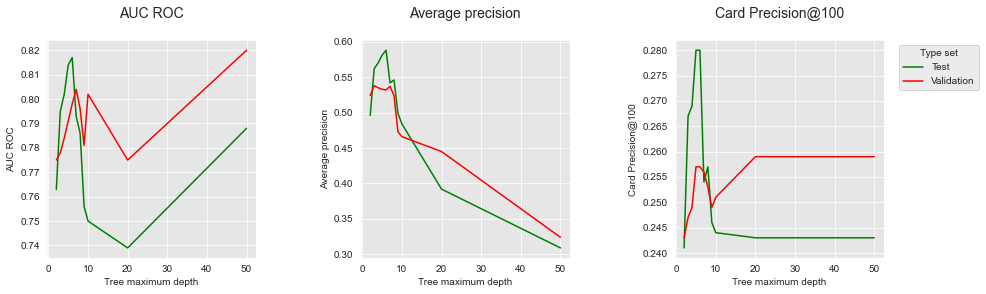

In [21]:
get_performances_plots(performances_df_validation, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'],expe_type_color_list=['#008000','#FF0000'])

The plots show interesting insights into the ability of the validation set to provide both a good performance estimate for the test set and a way to select the best model. First, it should be noted that the performances obtained on both sets differ in terms of exact values, but tend to follow similar dynamics. Exact matches in terms of performances cannot be expected, since different sets are used for training and testing. 

The performances obtained on the validation set however provide guidance in selecting the tree depths that can maximize the performance on the test set. This is particularly true for the performance in terms of AP, where the optimal depth is in the range 3 to 8. 

The AUC ROC and CP@100 however exhibit more discrepancies, and appear less well suited for determining the optimal tree depth. In particular, their value is maximized on the validation set for a decision tree depth of 50, whereas such a tree depth provides low performance on the test set.

## Repeated hold-out validation

Prediction models, and their performances, are often sensitive to the data used for training. Slightly changing the training set may result in different prediction models and performances. 

An alternative to the hold-out validation procedures consists in training different prediction models with random samples of the training data. This allows to get different estimates of the validation error, therefore providing confidence intervals on the expected performances, instead of a single estimate. The procedure is referred to as the *repeated hold-out* validation procedure.

Repeated hold-out validation can be implemented by slightly amending the `get_performances_train_test_sets` function defined above. The function takes two more parameters:

* `n_folds`: The number of random subsets that will be used to train the different prediction models
* `sampling_ratio`: The proportion of data that will be randomly sampled each time from the training data.


In [24]:
def repeated_holdout_validation(transactions_df, classifier, 
                                start_date_training, 
                                delta_train=7, delta_delay=7, delta_test=7,
                                n_folds=4,
                                sampling_ratio=0.7,
                                top_k_list=[100],
                                type_test="Test", parameter_summary=""):

    performances_df_folds=pd.DataFrame()
    
    start_time=time.time() 
    
    for fold in range(n_folds):
        
        # Get the training and test sets
        (train_df, test_df)=get_train_test_set(transactions_df,
                                               start_date_training,
                                               delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_test,
                                               sampling_ratio=sampling_ratio,
                                               random_state=fold)
    
        
        # Fit model  
        model_and_predictions_dictionary = fit_model_and_get_predictions(classifier, train_df, test_df, 
                                                                         input_features, output_feature)
        
        # Compute fraud detection performances
        test_df['predictions']=model_and_predictions_dictionary['predictions_test']
        performances_df_test=performance_assessment(test_df, top_k_list=top_k_list)
        performances_df_test.columns=performances_df_test.columns.values+' '+type_test
        
        train_df['predictions']=model_and_predictions_dictionary['predictions_train']
        performances_df_train=performance_assessment(train_df, top_k_list=top_k_list)
        performances_df_train.columns=performances_df_train.columns.values+' Train'
    
        performances_df_folds=performances_df_folds.append(pd.concat([performances_df_test,performances_df_train],axis=1))
    
    execution_time=time.time()-start_time
    
    performances_df_folds_mean=performances_df_folds.mean()
    performances_df_folds_std=performances_df_folds.std(ddof=0)
    
    performances_df_folds_mean=pd.DataFrame(performances_df_folds_mean).transpose()
    performances_df_folds_std=pd.DataFrame(performances_df_folds_std).transpose()
    performances_df_folds_std.columns=performances_df_folds_std.columns.values+" Std"
    performances_df=pd.concat([performances_df_folds_mean,performances_df_folds_std],axis=1)
    
    performances_df['Execution time']=execution_time
    
    performances_df['Parameters summary']=parameter_summary
    
    return performances_df, performances_df_folds


Let us for example compute the validation accuracy with a decision tree of depth 2.

In [25]:
classifier = sklearn.tree.DecisionTreeClassifier(max_depth = 2, random_state=0)

performances_df_repeated_holdout_summary, \
performances_df_repeated_holdout_folds=repeated_holdout_validation(
    transactions_df, classifier, 
    start_date_training=start_date_training_with_valid, 
    delta_train=delta_train, 
    delta_delay=delta_delay, 
    delta_test=delta_test, 
    n_folds=4,
    sampling_ratio=0.7,
    type_test="Validation", parameter_summary='2'
)

The `repeated_holdout_validation` function returns two DataFrames:

* `performances_df_repeated_holdout_summary`: Summary of performance metrics over all folds, in terms of mean and standard variance for each performance metric.
* `accuracy_df_repeated_holdout_folds`: Performance metrics obtained in each fold

In [26]:
performances_df_repeated_holdout_summary

,AUC ROC Validation,Average precision Validation,Card Precision@100 Validation,AUC ROC Train,Average precision Train,Card Precision@100 Train,AUC ROC Validation Std,Average precision Validation Std,Card Precision@100 Validation Std,AUC ROC Train Std,Average precision Train Std,Card Precision@100 Train Std,Execution time,Parameters summary
0,0.776,0.51875,0.24475,0.79475,0.57575,0.2985,0.001225,0.006495,0.001785,0.003961,0.008871,0.009341,3.287545,2


In [27]:
performances_df_repeated_holdout_folds

,AUC ROC Validation,Average precision Validation,Card Precision@100 Validation,AUC ROC Train,Average precision Train,Card Precision@100 Train
0,0.778,0.514,0.247,0.797,0.569,0.311
0,0.776,0.511,0.246,0.798,0.572,0.304
0,0.775,0.523,0.243,0.788,0.571,0.289
0,0.775,0.527,0.243,0.796,0.591,0.290


Let us then compute the expected performances for different depths of decision trees (with values $[2,3,4,5,6,7,8,9,10,20,50]$).

In [28]:
list_params = [2,3,4,5,6,7,8,9,10,20,50]

performances_df_repeated_holdout=pd.DataFrame()

start_time=time.time()

for max_depth in list_params:
    
    print("Computing performances for a decision tree with max_depth="+str(max_depth))
    
    classifier = sklearn.tree.DecisionTreeClassifier(max_depth = max_depth, random_state=0)

    performances_df_repeated_holdout=performances_df_repeated_holdout.append(
        repeated_holdout_validation(
            transactions_df, classifier, 
            start_date_training=start_date_training_with_valid, 
            delta_train=delta_train, 
            delta_delay=delta_delay, 
            delta_test=delta_test,
            n_folds=4,
            sampling_ratio=0.7,
            type_test="Validation", parameter_summary=max_depth
        )[0]
    )
    
performances_df_repeated_holdout.reset_index(inplace=True,drop=True)

print("Total execution time: "+str(round(time.time()-start_time,2))+"s")


Computing performances for a decision tree with max_depth=2
Computing performances for a decision tree with max_depth=3
Computing performances for a decision tree with max_depth=4
Computing performances for a decision tree with max_depth=5
Computing performances for a decision tree with max_depth=6
Computing performances for a decision tree with max_depth=7
Computing performances for a decision tree with max_depth=8
Computing performances for a decision tree with max_depth=9
Computing performances for a decision tree with max_depth=10
Computing performances for a decision tree with max_depth=20
Computing performances for a decision tree with max_depth=50
Total execution time: 39.19s


In [30]:
performances_df_repeated_holdout

,AUC ROC Validation,Average precision Validation,Card Precision@100 Validation,AUC ROC Train,Average precision Train,Card Precision@100 Train,AUC ROC Validation Std,Average precision Validation Std,Card Precision@100 Validation Std,AUC ROC Train Std,Average precision Train Std,Card Precision@100 Train Std,Execution time,Parameters summary
0,0.77600,0.51875,0.24475,0.79475,0.57575,0.29850,0.001225,0.006495,0.001785,0.003961,0.008871,0.009341,3.002673,2
1,0.78200,0.53800,0.24900,0.80650,0.60525,0.30675,0.002449,0.003937,0.001414,0.002958,0.003832,0.007189,2.892724,3
2,0.78550,0.54100,0.25125,0.81425,0.62325,0.31075,0.006185,0.007649,0.006180,0.004969,0.006220,0.007790,3.032751,4
3,0.78200,0.52900,0.24825,0.82025,0.63625,0.31175,0.008515,0.014036,0.003700,0.007529,0.009575,0.008871,3.156154,5
4,0.78350,0.51725,0.25225,0.82875,0.64800,0.31825,0.007018,0.006300,0.005761,0.007395,0.008062,0.006759,3.217496,6
5,0.78450,0.51725,0.25175,0.83825,0.66375,0.32250,0.005025,0.015833,0.003491,0.002773,0.010779,0.005500,3.332991,7
6,0.78700,0.51150,0.25125,0.84625,0.67950,0.32400,0.009274,0.020267,0.002681,0.002861,0.003905,0.006285,3.418987,8
7,0.78400,0.50150,0.24850,0.85625,0.69000,0.32625,0.010700,0.024005,0.003841,0.011584,0.005244,0.005890,3.500675,9
8,0.79675,0.49800,0.25075,0.87400,0.70425,0.33000,0.015352,0.024321,0.003112,0.009192,0.007562,0.008832,3.656681,10
9,0.80125,0.45425,0.26300,0.97150,0.86500,0.37025,0.014289,0.030938,0.004637,0.008789,0.016837,0.011099,4.784067,20


For better vizualization, let us plot the validation and test accuracies in terms of AUC ROC, AP, and CP@100 as a function of the decision tree depth. 

In [31]:
performances_df

,AUC ROC Test,Average precision Test,Card Precision@100 Test,AUC ROC Train,Average precision Train,Card Precision@100 Train,Execution time,Parameters summary
0,0.763,0.496,0.241,0.802,0.586,0.394,0.468689,2
1,0.795,0.562,0.267,0.815,0.615,0.409,0.582330,3
2,0.802,0.570,0.269,0.829,0.635,0.411,0.550253,4
3,0.814,0.581,0.280,0.835,0.649,0.419,0.580715,5
4,0.817,0.588,0.280,0.842,0.662,0.421,0.642127,6
5,0.793,0.542,0.254,0.876,0.679,0.427,0.666566,7
6,0.786,0.546,0.257,0.884,0.717,0.436,0.727614,8
7,0.756,0.499,0.246,0.896,0.737,0.437,0.773424,9
8,0.750,0.484,0.244,0.901,0.756,0.440,0.782423,10
9,0.739,0.392,0.243,0.974,0.907,0.506,1.194687,20


In [32]:
performances_df_repeated_holdout['AUC ROC Test']=performances_df['AUC ROC Test']
performances_df_repeated_holdout['Average precision Test']=performances_df['Average precision Test']
performances_df_repeated_holdout['Card Precision@100 Test']=performances_df['Card Precision@100 Test']


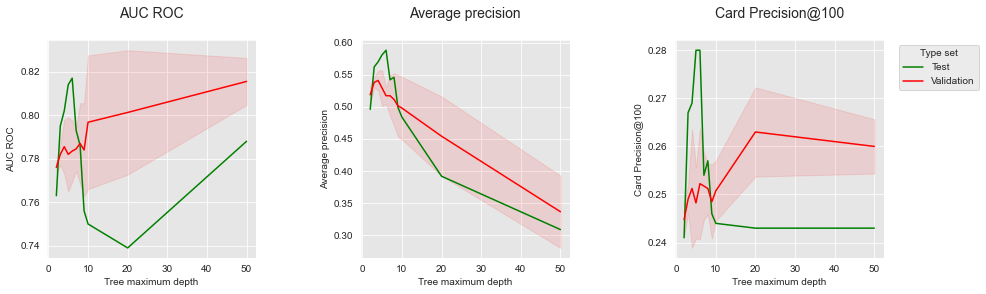

In [33]:
get_performances_plots(
    performances_df_repeated_holdout, 
    performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
    expe_type_list=['Test','Validation'],expe_type_color_list=['#008000','#FF0000']
)

The repeated hold-out validation offers a better view of the expected performances, by providing confidence intervals. Qualitatively, the results are similar to the hold-out validation. The AP provides the most accurate proxy to the expected performance on the test set. The AUC ROC and CP@100 provide poorer estimates of the test performance.



(Prequential_validation)=
## Prequential validation

The repeated hold-out validation relies on random subsets of the same training data to build prediction models. A limitation of this approach is that it reduces the expected performances of the models, as only subsets of data are used for training. 

An alternative validation procedure consists in using training sets of similar sizes, taken from older historical data. The scheme is called *prequential validation*, and is illustrated in Fig. 5. Each fold shifts the training and validation sets by one block in the past. 

![alt text](images/stream_prequential_1block.png)
<div align="center">Fig. 5. Prequential validation: Each fold shifts the training and validation sets by one block in the past. The validation set has the same length as the test.</div>

The implementation is similar than the repeated hold-out validation. The only difference is that, for each fold, the starting dates for the training and validation sets are shifted by one block. The implementation is provided below, with the function `prequential_validation`. 


In [34]:
def prequential_validation(transactions_df, classifier, 
                           start_date_training, 
                           delta_train=7, 
                           delta_delay=7, 
                           delta_assessment=7,
                           n_folds=4,
                           top_k_list=[100],
                           type_test="Test", parameter_summary=""):

    performances_df_folds=pd.DataFrame()
    
    start_time=time.time() 
    
    for fold in range(n_folds):
        
        start_date_training_fold=start_date_training-datetime.timedelta(days=fold*delta_assessment)
        
        # Get the training and test sets
        (train_df, test_df)=get_train_test_set(transactions_df,
                                               start_date_training=start_date_training_fold,
                                               delta_train=delta_train,
                                               delta_delay=delta_delay,
                                               delta_test=delta_assessment)
    
        # Fit model
        model_and_predictions_dictionary = fit_model_and_get_predictions(classifier, train_df, test_df, 
                                                                     input_features, output_feature)
        
        # Compute fraud detection performances    
        test_df['predictions']=model_and_predictions_dictionary['predictions_test']
        performances_df_test=performance_assessment(test_df, top_k_list=top_k_list, rounded=False)
        performances_df_test.columns=performances_df_test.columns.values+' '+type_test
        
        train_df['predictions']=model_and_predictions_dictionary['predictions_train']
        performances_df_train=performance_assessment(train_df, top_k_list=top_k_list, rounded=False)
        performances_df_train.columns=performances_df_train.columns.values+' Train'
    
        performances_df_folds=performances_df_folds.append(pd.concat([performances_df_test,performances_df_train],axis=1))
    
    execution_time=time.time()-start_time
    
    performances_df_folds_mean=performances_df_folds.mean()
    performances_df_folds_std=performances_df_folds.std(ddof=0)
    
    performances_df_folds_mean=pd.DataFrame(performances_df_folds_mean).transpose()
    performances_df_folds_std=pd.DataFrame(performances_df_folds_std).transpose()
    performances_df_folds_std.columns=performances_df_folds_std.columns.values+" Std"
    performances_df=pd.concat([performances_df_folds_mean,performances_df_folds_std],axis=1)
    
    performances_df['Execution time']=execution_time
    
    performances_df['Parameters summary']=parameter_summary
    
    return performances_df, performances_df_folds


Let us for example compute the validation performance with a decision tree of depth 2.


In [35]:
classifier = sklearn.tree.DecisionTreeClassifier(max_depth = 2, random_state=0)

performances_df_prequential_summary, performances_df_prequential_folds=prequential_validation(
    transactions_df, classifier, 
    start_date_training=start_date_training_with_valid, 
    delta_train=delta_train, 
    delta_delay=delta_delay, 
    delta_assessment=delta_valid, 
    n_folds=4,
    type_test="Validation", parameter_summary='2'
)

As with the function `repeated_holdout_validation`, the `prequential_validation` function returns two DataFrames:

* `performances_df_prequential_summary`: Summary of performance metrics over all folds, in terms of mean and standard variance for each performance metric.
* `performances_df_prequential_folds`: Performance metrics obtained in each fold

In [36]:
performances_df_prequential_summary

,AUC ROC Validation,Average precision Validation,Card Precision@100 Validation,AUC ROC Train,Average precision Train,Card Precision@100 Train,AUC ROC Validation Std,Average precision Validation Std,Card Precision@100 Validation Std,AUC ROC Train Std,Average precision Train Std,Card Precision@100 Train Std,Execution time,Parameters summary
0,0.790786,0.549767,0.256429,0.804231,0.593561,0.4025,0.012035,0.022134,0.014481,0.013359,0.018224,0.040474,3.364997,2


In [37]:
performances_df_prequential_folds

,AUC ROC Validation,Average precision Validation,Card Precision@100 Validation,AUC ROC Train,Average precision Train,Card Precision@100 Train
0,0.775012,0.523548,0.242857,0.791004,0.576732,0.398571
0,0.808739,0.584663,0.242857,0.791234,0.576985,0.347143
0,0.791405,0.542531,0.262857,0.813726,0.599954,0.402857
0,0.787988,0.548326,0.277143,0.820960,0.620572,0.461429


Let us then compute the expected performances for different depths of decision trees, ranging from $[2,3,4,5,6,7,8,9,10,20,50]$.

In [38]:
list_params = [2,3,4,5,6,7,8,9,10,20,50]

start_time=time.time()

performances_df_prequential=pd.DataFrame()

for max_depth in list_params:
    
    print("Computing performances for a decision tree with max_depth="+str(max_depth))
    
    classifier = sklearn.tree.DecisionTreeClassifier(max_depth = max_depth, random_state=0)

    performances_df_prequential=performances_df_prequential.append(
        prequential_validation(
            transactions_df, classifier,
            start_date_training=start_date_training_with_valid, 
            delta_train=delta_train, 
            delta_delay=delta_delay, 
            delta_assessment=delta_test,
            n_folds=4,
            type_test="Validation", parameter_summary=max_depth
        )[0]
    )
    
performances_df_prequential.reset_index(inplace=True,drop=True)

print("Total execution time: "+str(round(time.time()-start_time,2))+"s")


Computing performances for a decision tree with max_depth=2
Computing performances for a decision tree with max_depth=3
Computing performances for a decision tree with max_depth=4
Computing performances for a decision tree with max_depth=5
Computing performances for a decision tree with max_depth=6
Computing performances for a decision tree with max_depth=7
Computing performances for a decision tree with max_depth=8
Computing performances for a decision tree with max_depth=9
Computing performances for a decision tree with max_depth=10
Computing performances for a decision tree with max_depth=20
Computing performances for a decision tree with max_depth=50
Total execution time: 52.82s


In [39]:
performances_df_prequential

,AUC ROC Validation,Average precision Validation,Card Precision@100 Validation,AUC ROC Train,Average precision Train,Card Precision@100 Train,AUC ROC Validation Std,Average precision Validation Std,Card Precision@100 Validation Std,AUC ROC Train Std,Average precision Train Std,Card Precision@100 Train Std,Execution time,Parameters summary
0,0.790786,0.549767,0.256429,0.804231,0.593561,0.402500,0.012035,0.022134,0.014481,0.013359,0.018224,0.040474,3.666392,2
1,0.802717,0.573414,0.267143,0.818140,0.623562,0.421429,0.017607,0.027186,0.016067,0.011437,0.016412,0.032214,3.414093,3
2,0.800690,0.554134,0.264286,0.825978,0.644766,0.426429,0.017878,0.038293,0.014321,0.009928,0.018337,0.034144,3.765976,4
3,0.804218,0.546094,0.267857,0.831289,0.657368,0.431429,0.016505,0.042197,0.013869,0.007867,0.016387,0.029881,3.788764,5
4,0.798603,0.537006,0.264643,0.839032,0.669597,0.432143,0.024225,0.037056,0.008474,0.002592,0.012448,0.028383,4.170064,6
5,0.795636,0.530609,0.262500,0.846446,0.681837,0.436429,0.023144,0.040323,0.006804,0.005559,0.008949,0.026351,4.368153,7
6,0.795142,0.516246,0.260714,0.859548,0.694885,0.440000,0.023081,0.033545,0.009715,0.008063,0.009498,0.031380,4.966671,8
7,0.785849,0.505189,0.260357,0.864869,0.717259,0.447500,0.026249,0.040393,0.009813,0.011527,0.015346,0.028453,4.757738,9
8,0.786784,0.493543,0.257143,0.887622,0.727672,0.448571,0.031165,0.048307,0.009949,0.011532,0.018154,0.028962,5.247802,10
9,0.780408,0.450980,0.264286,0.964275,0.862459,0.496786,0.022168,0.031413,0.007890,0.007512,0.014831,0.031483,6.802245,20


Let us plot the validation and test performances in terms of AUC ROC, AP, and CP@100, as a function of the decision tree depth. 

In [40]:
performances_df_prequential['AUC ROC Test']=performances_df['AUC ROC Test']
performances_df_prequential['Average precision Test']=performances_df['Average precision Test']
performances_df_prequential['Card Precision@100 Test']=performances_df['Card Precision@100 Test']


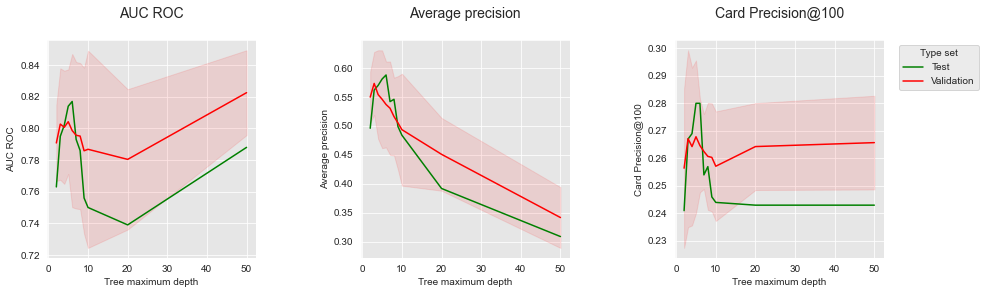

In [41]:
get_performances_plots(performances_df_prequential, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'])

We can also compute the performances on the next `n_folds` weeks using the same code, but setting the starting day for training in such a way that estimates for the test period are obtained. This allows to provide confidence intervals for the performances on the test data.

In [42]:
list_params = [2,3,4,5,6,7,8,9,10,20,50]

start_time=time.time()

n_folds=4

performances_df_prequential_test=pd.DataFrame()

for max_depth in list_params:
    
    classifier = sklearn.tree.DecisionTreeClassifier(max_depth = max_depth, random_state=0)

    performances_df_prequential_test=performances_df_prequential_test.append(
        prequential_validation(
            transactions_df, classifier, 
            start_date_training=start_date_training 
                +datetime.timedelta(days=delta_test*(n_folds-1)), 
            delta_train=delta_train, 
            delta_delay=delta_delay, 
            delta_assessment=delta_test,
            n_folds=n_folds,
            type_test="Test", parameter_summary=max_depth
        )[0]
    )
    
performances_df_prequential_test.reset_index(inplace=True,drop=True)

print("Total execution time: "+str(round(time.time()-start_time,2))+"s")


Total execution time: 53.54s


In [43]:
performances_df_prequential_test

,AUC ROC Test,Average precision Test,Card Precision@100 Test,AUC ROC Train,Average precision Train,Card Precision@100 Train,AUC ROC Test Std,Average precision Test Std,Card Precision@100 Test Std,AUC ROC Train Std,Average precision Train Std,Card Precision@100 Train Std,Execution time,Parameters summary
0,0.791909,0.541761,0.265000,0.807785,0.592120,0.394643,0.017769,0.031476,0.019756,0.011559,0.017914,0.004088,3.404004,2
1,0.809012,0.578885,0.281429,0.820076,0.623315,0.410714,0.009125,0.014434,0.015940,0.007795,0.015303,0.003712,3.928414,3
2,0.812555,0.601088,0.282500,0.829963,0.645225,0.412500,0.010319,0.020216,0.015199,0.006963,0.015748,0.005285,3.725971,4
3,0.810138,0.600306,0.284286,0.835835,0.658589,0.416071,0.008586,0.016797,0.004286,0.008285,0.015249,0.008353,4.961377,5
4,0.804437,0.585132,0.281429,0.847145,0.671259,0.420000,0.007974,0.005053,0.007626,0.007900,0.016706,0.006145,4.066389,6
5,0.782710,0.554860,0.268929,0.859658,0.692724,0.427500,0.012483,0.011771,0.009813,0.013379,0.012199,0.012990,4.978631,7
6,0.774783,0.544933,0.263571,0.865567,0.708766,0.429643,0.014568,0.003392,0.007593,0.015050,0.009896,0.012951,4.452925,8
7,0.761763,0.520208,0.258571,0.877844,0.721114,0.431786,0.012098,0.012309,0.009949,0.012280,0.014920,0.012792,5.070283,9
8,0.758138,0.504909,0.257500,0.881659,0.737896,0.435357,0.011140,0.013154,0.010467,0.012795,0.012402,0.012990,5.592131,10
9,0.754024,0.439422,0.261071,0.969552,0.878847,0.491429,0.009848,0.034828,0.014335,0.010886,0.026480,0.021500,6.487757,20


Let us plot the validation and test accuracies in terms of AUC ROC, AP and CP@100, as a function of the decision tree depth. 

In [44]:
performances_df_prequential['AUC ROC Test']=performances_df_prequential_test['AUC ROC Test']
performances_df_prequential['Average precision Test']=performances_df_prequential_test['Average precision Test']
performances_df_prequential['Card Precision@100 Test']=performances_df_prequential_test['Card Precision@100 Test']
performances_df_prequential['AUC ROC Test Std']=performances_df_prequential_test['AUC ROC Test Std']
performances_df_prequential['Average precision Test Std']=performances_df_prequential_test['Average precision Test Std']
performances_df_prequential['Card Precision@100 Test Std']=performances_df_prequential_test['Card Precision@100 Test Std']


In [45]:
performances_df_prequential

,AUC ROC Validation,Average precision Validation,Card Precision@100 Validation,AUC ROC Train,Average precision Train,Card Precision@100 Train,AUC ROC Validation Std,Average precision Validation Std,Card Precision@100 Validation Std,AUC ROC Train Std,Average precision Train Std,Card Precision@100 Train Std,Execution time,Parameters summary,AUC ROC Test,Average precision Test,Card Precision@100 Test,AUC ROC Test Std,Average precision Test Std,Card Precision@100 Test Std
0,0.790786,0.549767,0.256429,0.804231,0.593561,0.402500,0.012035,0.022134,0.014481,0.013359,0.018224,0.040474,3.666392,2,0.791909,0.541761,0.265000,0.017769,0.031476,0.019756
1,0.802717,0.573414,0.267143,0.818140,0.623562,0.421429,0.017607,0.027186,0.016067,0.011437,0.016412,0.032214,3.414093,3,0.809012,0.578885,0.281429,0.009125,0.014434,0.015940
2,0.800690,0.554134,0.264286,0.825978,0.644766,0.426429,0.017878,0.038293,0.014321,0.009928,0.018337,0.034144,3.765976,4,0.812555,0.601088,0.282500,0.010319,0.020216,0.015199
3,0.804218,0.546094,0.267857,0.831289,0.657368,0.431429,0.016505,0.042197,0.013869,0.007867,0.016387,0.029881,3.788764,5,0.810138,0.600306,0.284286,0.008586,0.016797,0.004286
4,0.798603,0.537006,0.264643,0.839032,0.669597,0.432143,0.024225,0.037056,0.008474,0.002592,0.012448,0.028383,4.170064,6,0.804437,0.585132,0.281429,0.007974,0.005053,0.007626
5,0.795636,0.530609,0.262500,0.846446,0.681837,0.436429,0.023144,0.040323,0.006804,0.005559,0.008949,0.026351,4.368153,7,0.782710,0.554860,0.268929,0.012483,0.011771,0.009813
6,0.795142,0.516246,0.260714,0.859548,0.694885,0.440000,0.023081,0.033545,0.009715,0.008063,0.009498,0.031380,4.966671,8,0.774783,0.544933,0.263571,0.014568,0.003392,0.007593
7,0.785849,0.505189,0.260357,0.864869,0.717259,0.447500,0.026249,0.040393,0.009813,0.011527,0.015346,0.028453,4.757738,9,0.761763,0.520208,0.258571,0.012098,0.012309,0.009949
8,0.786784,0.493543,0.257143,0.887622,0.727672,0.448571,0.031165,0.048307,0.009949,0.011532,0.018154,0.028962,5.247802,10,0.758138,0.504909,0.257500,0.011140,0.013154,0.010467
9,0.780408,0.450980,0.264286,0.964275,0.862459,0.496786,0.022168,0.031413,0.007890,0.007512,0.014831,0.031483,6.802245,20,0.754024,0.439422,0.261071,0.009848,0.034828,0.014335


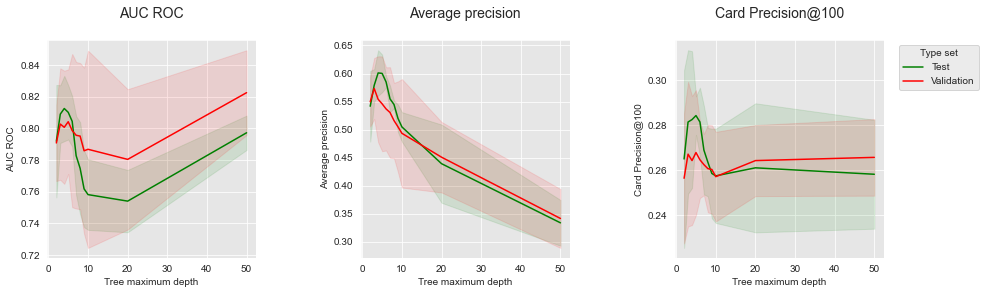

In [46]:
get_performances_plots(performances_df_prequential, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'])

The resulting plot shows a better agreement between the validation and test performances for the three performance metrics. The AUC ROC remains problematic, since it would select a depth of 50 as the best performance for the validation set, whereas optimal depths are in the range 3 to 6. The AP and CP@100 however follow similar trends for the validation and test set. 

The prequential validation offers the most robust way to perform model selection and will be the preferred approach in the rest of this book. It should however be noted that it is computationally intensive since it requires the creation of several prediction models for each tested model parameter.

(Sklearn_Validation_Pipeline)=
## Integration in Scikit-learn 

Scikit-learn (also known as *sklearn*) is the reference library for machine learning in Python. Since validation and model selection are essential steps in the design of machine learning prediction models, sklearn provides [a wide range of techniques for assessing and validating prediction models](https://scikit-learn.org/stable/model_selection.html).

Sklearn however offers few possibilities for performing validation on sequential data. In particular, the prequential validation presented in the previous section, and the Card Precision metric are not provided.

This last section aims at bridging this gap, by adding both prequential validation and the CP metric to the validation and model selection pipelines provided by sklearn. The benefits will be to gain access to high-level functions from the sklearn library. These include, among others, the ability to 

* easily parallelize code execution
* rely on sklearn *pipelines* for data transformation
* rely on different strategies for hyperparameter tuning (exhaustive search, random search, ...). 




### Prequential splitting

Scikit-learn provides seven different strategies for splitting data for validation: `KFold`, `GroupKFold`, `ShuffleSplit`, `StratifiedKFold`, `GroupShuffleSplit`, `StratifiedShuffleSplit`, and `TimeSeriesSplit`. A visualization of these splitting strategies is provided [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html). None of these allows the prequential splitting of data illustrated in Fig. 5.

Let us define a `prequentialSplit` function, that returns the indices of the training and test sets for each of the folds of a prequential split. 


In [47]:
def prequentialSplit(transactions_df,
                     start_date_training, 
                     n_folds=4, 
                     delta_train=7,
                     delta_delay=7,
                     delta_assessment=7):
    
    prequential_split_indices=[]
        
    # For each fold
    for fold in range(n_folds):
        
        # Shift back start date for training by the fold index times the assessment period (delta_assessment)
        # (See Fig. 5)
        start_date_training_fold = start_date_training-datetime.timedelta(days=fold*delta_assessment)
        
        # Get the training and test (assessment) sets
        (train_df, test_df)=get_train_test_set(transactions_df,
                                               start_date_training=start_date_training_fold,
                                               delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_assessment)
    
        # Get the indices from the two sets, and add them to the list of prequential splits
        indices_train=list(train_df.index)
        indices_test=list(test_df.index)
        
        prequential_split_indices.append((indices_train,indices_test))
    
    return prequential_split_indices

### Card Precision top-k

Custom metrics can be implemented in sklearn thanks to the [`make_scorer`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) factory function. The computation of the Card Precision top-k requires the scoring function to be aware of the customer ID and the day of the transation (see Section [Precision Top K Metrics](Precision_Top_K_Metrics)). This is done by passing the `transactions_df` DataFrame as an argument to the function. More details on the design of custom scoring functions can be found [here](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring).



In [48]:
def card_precision_top_k_custom(y_true, y_pred, top_k, transactions_df):
    
    # Let us create a predictions_df DataFrame, that contains all transactions matching the indices of the current fold
    # (indices of the y_true vector)
    predictions_df=transactions_df.iloc[y_true.index.values].copy()
    predictions_df['predictions']=y_pred
    
    # Compute the CP@k using the function implemented in Chapter 4, Section 4.2
    nb_compromised_cards_per_day,card_precision_top_k_per_day_list,mean_card_precision_top_k=\
        card_precision_top_k(predictions_df, top_k)
    
    # Return the mean_card_precision_top_k
    return mean_card_precision_top_k

# Only keep columns that are needed as argument to the custom scoring function
# (in order to reduce the serialization time of transaction dataset)
transactions_df_scorer=transactions_df[['CUSTOMER_ID', 'TX_FRAUD','TX_TIME_DAYS']]

# Make scorer using card_precision_top_k_custom
card_precision_top_100 = sklearn.metrics.make_scorer(card_precision_top_k_custom, 
                                                     needs_proba=True, 
                                                     top_k=100, 
                                                     transactions_df=transactions_df_scorer)



### Grid search

Sklearn allows to automate the fitting and assessment of models with different hyperparameters by means of the [GridSearchCV function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). 

Its main parameters are

* `estimator`: The estimator to use, which will be a decision tree in the following example.
* `param_grid`: The set of hyperparameters for the estimator. We will vary the decision tree depth (`max_depth`) parameter, and set the random state (`random_state`) for reproduciblity.
* `scoring`: The scoring functions to use. We will use the AUC ROC, Average Precision, and CP@100.   
* `n_jobs`: The number of cores to use. We will set it to -1, that is, to using all the available cores. 
* `refit`: Whether the model should be fitted with all data after the cross validation. This will be set to false, since we only require the results of the cross validation.
* `cv`: The cross-validation splitting strategy. The prequential validation will be used, by passing the indices returned by the `prequentialSplit` function.

Let us set these parameters, and instantiate a `GridSearchCV` object.

In [49]:
# Estimator to use
classifier = sklearn.tree.DecisionTreeClassifier()

# Hyperparameters to test
parameters = {'clf__max_depth':[2,4], 'clf__random_state':[0]}

# Scoring functions. AUC ROC and Average Precision are readily available from sklearn 
# with `auc_roc` and `average_precision`. Card Precision@100 was implemented with the make_scorer factory function. 
scoring = {'roc_auc':'roc_auc',
           'average_precision': 'average_precision',
           'card_precision@100': card_precision_top_100
           }

# A pipeline is created to scale data before fitting a model
estimators = [('scaler', sklearn.preprocessing.StandardScaler()), ('clf', classifier)]
pipe = sklearn.pipeline.Pipeline(estimators)

# Indices for the prequential validation are obtained with the prequentialSplit function
prequential_split_indices = prequentialSplit(transactions_df,
                                             start_date_training_with_valid, 
                                             n_folds=n_folds,
                                             delta_train=delta_train, 
                                             delta_delay=delta_delay, 
                                             delta_assessment=delta_valid)

# Let us instantiate the GridSearchCV
grid_search = sklearn.model_selection.GridSearchCV(pipe, param_grid=parameters, scoring=scoring, \
                                                   cv=prequential_split_indices, refit=False, n_jobs=-1,verbose=0)

# And select the input features, and output feature
X=transactions_df[input_features]
y=transactions_df[output_feature]



The fitting and assessment is performed by calling the `fit` function of the `grid_search` object.

In [50]:
%time grid_search.fit(X, y)

print("Finished CV fitting")

CPU times: user 152 ms, sys: 259 ms, total: 411 ms
Wall time: 6.51 s
Finished CV fitting


The results of the cross validation can be retrieved with the `cv_results_` attribute. It contains the scoring for each fold and scoring metrics, together with statistics on the execution times. 

In [51]:
grid_search.cv_results_

{'mean_fit_time': array([1.05854368, 1.27579147]),
 'std_fit_time': array([0.0081484 , 0.01675179]),
 'mean_score_time': array([0.29740781, 0.21103078]),
 'std_score_time': array([0.00725061, 0.00444517]),
 'param_clf__max_depth': masked_array(data=[2, 4],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_clf__random_state': masked_array(data=[0, 0],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'clf__max_depth': 2, 'clf__random_state': 0},
  {'clf__max_depth': 4, 'clf__random_state': 0}],
 'split0_test_roc_auc': array([0.7750121 , 0.78393251]),
 'split1_test_roc_auc': array([0.80873906, 0.82871798]),
 'split2_test_roc_auc': array([0.79140481, 0.78643512]),
 'split3_test_roc_auc': array([0.78798838, 0.80367453]),
 'mean_test_roc_auc': array([0.79078609, 0.80069003]),
 'std_test_roc_auc': array([0.01203472, 0.01787799]),
 'rank_test_roc_auc': array([2, 1], dtype=int32),
 'split0_test_avera

Let us rearrange these results in a more readable format:

In [52]:
performances_df=pd.DataFrame()

expe_type="Validation"

performance_metrics_list_grid=['roc_auc', 'average_precision', 'card_precision@100']
performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100']


for i in range(len(performance_metrics_list_grid)):
    performances_df[performance_metrics_list[i]+' '+expe_type]=grid_search.cv_results_['mean_test_'+performance_metrics_list_grid[i]]
    performances_df[performance_metrics_list[i]+' '+expe_type+' Std']=grid_search.cv_results_['std_test_'+performance_metrics_list_grid[i]]

performances_df['Execution time']=grid_search.cv_results_['mean_fit_time']

performances_df['Parameters']=list(grid_search.cv_results_['params'])


In [53]:
performances_df

,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Execution time,Parameters
0,0.790786,0.012035,0.549767,0.022134,0.256429,0.014481,1.058544,"{'clf__max_depth': 2, 'clf__random_state': 0}"
1,0.800690,0.017878,0.554134,0.038293,0.264286,0.014321,1.275791,"{'clf__max_depth': 4, 'clf__random_state': 0}"


### Integration

The same results as in the [previous section](Prequential_validation) can be obtained using `GridSearchCV`. Let us first define a function `prequential_grid_search`, that implements the grid search as above: 

In [54]:
def prequential_grid_search(transactions_df, 
                            classifier, 
                            input_features, output_feature, 
                            parameters, scoring, 
                            start_date_training, 
                            n_folds=4,
                            expe_type='Test',
                            delta_train=7, 
                            delta_delay=7, 
                            delta_assessment=7,
                            performance_metrics_list_grid=['roc_auc'],
                            performance_metrics_list=['AUC ROC'],
                            n_jobs=-1):
    
    estimators = [('scaler', sklearn.preprocessing.StandardScaler()), ('clf', classifier)]
    pipe = sklearn.pipeline.Pipeline(estimators)
    
    prequential_split_indices=prequentialSplit(transactions_df,
                                               start_date_training=start_date_training, 
                                               n_folds=n_folds, 
                                               delta_train=delta_train, 
                                               delta_delay=delta_delay, 
                                               delta_assessment=delta_assessment)
    
    grid_search = sklearn.model_selection.GridSearchCV(pipe, parameters, scoring=scoring, cv=prequential_split_indices, refit=False, n_jobs=n_jobs)
    
    X=transactions_df[input_features]
    y=transactions_df[output_feature]

    grid_search.fit(X, y)
    
    performances_df=pd.DataFrame()
    
    for i in range(len(performance_metrics_list_grid)):
        performances_df[performance_metrics_list[i]+' '+expe_type]=grid_search.cv_results_['mean_test_'+performance_metrics_list_grid[i]]
        performances_df[performance_metrics_list[i]+' '+expe_type+' Std']=grid_search.cv_results_['std_test_'+performance_metrics_list_grid[i]]

    performances_df['Parameters']=grid_search.cv_results_['params']
    performances_df['Execution time']=grid_search.cv_results_['mean_fit_time']
    
    return performances_df

        

We can estimate the validation performances of a decision tree model for varying depth by setting `start_date_training` to `start_date_training_with_valid`.

In [55]:
start_time=time.time()

classifier = sklearn.tree.DecisionTreeClassifier()

parameters = {'clf__max_depth':[2,3,4,5,6,7,8,9,10,20,50], 'clf__random_state':[0]}

scoring = {'roc_auc':'roc_auc',
           'average_precision': 'average_precision',
           'card_precision@100': card_precision_top_100,
           }

performances_df_validation=prequential_grid_search(
    transactions_df, classifier, 
    input_features, output_feature,
    parameters, scoring, 
    start_date_training=start_date_training_with_valid,
    n_folds=n_folds,
    expe_type='Validation',
    delta_train=delta_train, 
    delta_delay=delta_delay, 
    delta_assessment=delta_valid,
    performance_metrics_list_grid=performance_metrics_list_grid,
    performance_metrics_list=performance_metrics_list)

print("Validation: Total execution time: "+str(round(time.time()-start_time,2))+"s")


Validation: Total execution time: 21.65s


And the test performances by setting `start_date_training` accordingly.

In [56]:
start_time=time.time()

performances_df_test=prequential_grid_search(
    transactions_df, classifier, 
    input_features, output_feature,
    parameters, scoring, 
    start_date_training=start_date_training+datetime.timedelta(days=(n_folds-1)*delta_test),
    n_folds=n_folds,
    expe_type='Test',
    delta_train=delta_train, 
    delta_delay=delta_delay, 
    delta_assessment=delta_test,
    performance_metrics_list_grid=performance_metrics_list_grid,
    performance_metrics_list=performance_metrics_list)

print("Test: Total execution time: "+str(round(time.time()-start_time,2))+"s")


Test: Total execution time: 21.02s


Let us concatenate the validation and test performances in a single DataFrame.

In [57]:
performances_df_validation.drop(columns=['Parameters','Execution time'], inplace=True)
performances_df=pd.concat([performances_df_test,performances_df_validation],axis=1)

In [58]:
# Use the max_depth as the label for plotting
parameters_dict=dict(performances_df['Parameters'])
max_depth=[parameters_dict[i]['clf__max_depth'] for i in range(len(parameters_dict))]
performances_df['Parameters summary']=max_depth

In [59]:
performances_df

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.791909,0.017769,0.541761,0.031476,0.265000,0.019756,"{'clf__max_depth': 2, 'clf__random_state': 0}",0.961201,0.790786,0.012035,0.549767,0.022134,0.256429,0.014481,2
1,0.809012,0.009125,0.578885,0.014434,0.281429,0.015940,"{'clf__max_depth': 3, 'clf__random_state': 0}",0.974105,0.802717,0.017607,0.573414,0.027186,0.267143,0.016067,3
2,0.812555,0.010319,0.601088,0.020216,0.282500,0.015199,"{'clf__max_depth': 4, 'clf__random_state': 0}",1.052066,0.800690,0.017878,0.554134,0.038293,0.264286,0.014321,4
3,0.810138,0.008586,0.600306,0.016797,0.284286,0.004286,"{'clf__max_depth': 5, 'clf__random_state': 0}",1.283144,0.804218,0.016505,0.546094,0.042197,0.267857,0.013869,5
4,0.804437,0.007974,0.585132,0.005053,0.281429,0.007626,"{'clf__max_depth': 6, 'clf__random_state': 0}",1.634223,0.798603,0.024225,0.537006,0.037056,0.264643,0.008474,6
5,0.782710,0.012483,0.554860,0.011771,0.268929,0.009813,"{'clf__max_depth': 7, 'clf__random_state': 0}",1.494083,0.795636,0.023144,0.530609,0.040323,0.262500,0.006804,7
6,0.774783,0.014568,0.544933,0.003392,0.263571,0.007593,"{'clf__max_depth': 8, 'clf__random_state': 0}",1.539149,0.795142,0.023081,0.516246,0.033545,0.260714,0.009715,8
7,0.761763,0.012098,0.520208,0.012309,0.258571,0.009949,"{'clf__max_depth': 9, 'clf__random_state': 0}",1.371046,0.785849,0.026249,0.505189,0.040393,0.260357,0.009813,9
8,0.758138,0.011140,0.504909,0.013154,0.257500,0.010467,"{'clf__max_depth': 10, 'clf__random_state': 0}",1.442724,0.786784,0.031165,0.493543,0.048307,0.257143,0.009949,10
9,0.754024,0.009848,0.439422,0.034828,0.261071,0.014335,"{'clf__max_depth': 20, 'clf__random_state': 0}",2.176944,0.780408,0.022168,0.450980,0.031413,0.264286,0.007890,20


Let us plot the performances for better visualization.

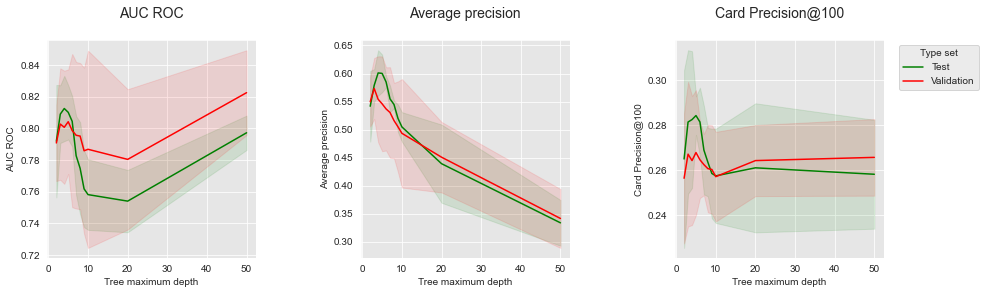

In [60]:
get_performances_plots(performances_df, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'],expe_type_color_list=['#008000','#FF0000'])

The results are the same as those obtained in Section [Prequential Validation](Prequential_Validation).